In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from sklearn.preprocessing import Normalizer
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

In [2]:
# Read data
data = loadmat("../data/breastw.mat")

X = data['X']
y = data['y']
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [3]:
# Normalize data
scaler = Normalizer()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

df = pd.concat([X_scaled, y], ignore_index=True, axis=1)
df.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

In [4]:
# Split normal data and outliers
df_normal = df[df.isOutlier == 0]
df_normal.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

df_outlier = df[df.isOutlier == 1]
df_outlier.columns = [f'X{i}' for i in range(1, X.shape[1] + 1)] + ['isOutlier']

df_normal.drop(["isOutlier"], axis=1, inplace=True)
df_outlier.drop(['isOutlier'], axis=1, inplace=True)

/Users/muratkoptur/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
# Split normal data as train and validation
train_size = int(len(df_normal) * 0.67)
valid_size = len(df_normal) - train_size

train_normal = df_normal.iloc[[i for i in range(train_size)], :]
valid_normal = df_normal.iloc[[i for i in range(train_size, len(df_normal))], :]

In [6]:
# Autoencoder model
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(9, activation='elu'),
            layers.Dense(6, activation='elu'),
            layers.Dense(3, activation='elu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(3, activation='elu'),
            layers.Dense(6, activation='elu'),
            layers.Dense(9, activation='elu')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
autoencoder = Autoencoder()

autoencoder.compile(optimizer=tf.keras.optimizers.SGD(),
                    loss=losses.mean_absolute_error,
                    metrics=['mean_absolute_error'])

# Fit on normal train data
history = autoencoder.fit(train_normal, train_normal,
                          epochs=100,
                          batch_size=100,
                          validation_data=(valid_normal, valid_normal),
                          callbacks=[EarlyStopping(patience=10)])

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

3/3 [==============================] - 0s 56ms/step - loss: 0.2858 - mean_absolute_error: 0.2858 - val_loss: 0.2792 - val_mean_absolute_error: 0.2792
Epoch 2/100
3/3 [==============================] - 0s 13ms/step - loss: 0.2795 - mean_absolute_error: 0.2795 - val_loss: 0.2729 - val_mean_absolute_error: 0.2729
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.2732 - mean_absolute_error: 0.2732 - val_loss: 0.2667 - val_mean_absolute_error: 0.2667
Epoch 4/100
3/3 [=====

Epoch 47/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1230 - mean_absolute_error: 0.1230 - val_loss: 0.1207 - val_mean_absolute_error: 0.1207
Epoch 48/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1217 - mean_absolute_error: 0.1217 - val_loss: 0.1195 - val_mean_absolute_error: 0.1195
Epoch 49/100
3/3 [==============================] - 0s 16ms/step - loss: 0.1204 - mean_absolute_error: 0.1204 - val_loss: 0.1183 - val_mean_absolute_error: 0.1183
Epoch 50/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1191 - mean_absolute_error: 0.1191 - val_loss: 0.1172 - val_mean_absolute_error: 0.1172
Epoch 51/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1180 - mean_absolute_error: 0.1180 - val_loss: 0.1161 - val_mean_absolute_error: 0.1161
Epoch 52/100
3/3 [==============================] - 0s 13ms/step - loss: 0.1169 - mean_absolute_error: 0.1169 - val_loss: 0.1151 - val_mean_absolute_error: 0.1151
Epoch 53/100
3/3 [====

3/3 [==============================] - 0s 13ms/step - loss: 0.0960 - mean_absolute_error: 0.0960 - val_loss: 0.0950 - val_mean_absolute_error: 0.0950
Epoch 98/100
3/3 [==============================] - 0s 12ms/step - loss: 0.0959 - mean_absolute_error: 0.0959 - val_loss: 0.0948 - val_mean_absolute_error: 0.0948
Epoch 99/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0957 - mean_absolute_error: 0.0957 - val_loss: 0.0947 - val_mean_absolute_error: 0.0947
Epoch 100/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0956 - mean_absolute_error: 0.0956 - val_loss: 0.0945 - val_mean_absolute_error: 0.0945


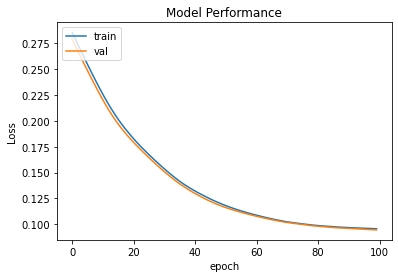

In [8]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Performance')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

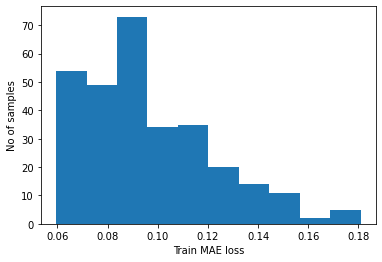

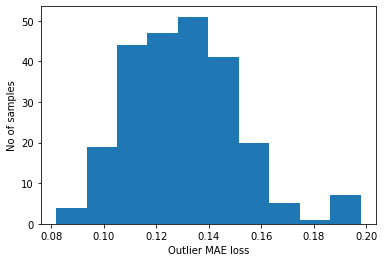

In [9]:
# Calculate reconstruction errors for normal and outliers
train_normal_pred = autoencoder.predict(train_normal)
train_mae_loss = np.mean(np.abs(train_normal_pred - train_normal), axis=1)
outlier_pred = autoencoder.predict(df_outlier)
outlier_mae_loss = np.mean(np.abs(outlier_pred - df_outlier), axis=1)

plt.hist(train_mae_loss)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

plt.hist(outlier_mae_loss)
plt.xlabel("Outlier MAE loss")
plt.ylabel("No of samples")
plt.show()

In [10]:
# Calculate MAE threshold for anomalies
# I'll choose threshold as median loss
threshold = np.median(train_mae_loss)
print("Reconstruction error threshold: ", threshold)
false_alarms = train_mae_loss > np.median(history.history['loss'])
anomalies = outlier_mae_loss > np.median(history.history['loss'])
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

# F1 score for classification
f1_score = np.sum(anomalies) / (np.sum(anomalies) + 1 / 2 * (np.sum(false_alarms) + anomalies.size - np.sum(anomalies)))
print(f1_score)

Reconstruction error threshold:  0.08910257036876344
Number of anomaly samples:  168
Indices of anomaly samples:  (array([  4,   7,   9,  10,  11,  12,  14,  15,  16,  17,  18,  19,  20,
        23,  24,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,
        37,  38,  40,  41,  43,  44,  48,  49,  51,  52,  53,  54,  55,
        59,  60,  62,  65,  66,  68,  69,  70,  72,  73,  74,  76,  77,
        78,  80,  81,  82,  84,  86,  88,  90,  91,  94,  95,  96,  97,
        98, 100, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       115, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 130, 132,
       134, 137, 138, 140, 144, 145, 146, 147, 148, 150, 151, 152, 153,
       155, 156, 157, 161, 163, 165, 167, 168, 169, 171, 173, 175, 176,
       177, 178, 179, 180, 181, 183, 185, 187, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 200, 202, 203, 204, 205, 206, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 227, 228,